In [8]:
%%capture cap --no-stderr
!pip install --upgrade google-cloud-bigquery==1.24.0
!pip install pyarrow
!pip install spacy
!pip install pandarallel
!pip install fastparquet

In [2]:
import os

os.makedirs("credentials", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("data", exist_ok=True)

try:
    with open("logs/env_setup.log", "w") as f:
        f.write(cap.stdout)
except:
    pass
finally:
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "credentials/Google_bigquery_auth.json"

In [1]:
import pandas as pd
import numpy as np

In [4]:
from google.cloud import bigquery

client = bigquery.Client()

QUERY = """
        SELECT committer.name, committer.time_sec, subject, message
        FROM `bigquery-public-data.github_repos.commits`
        WHERE LENGTH(message) > 6 AND LENGTH(message) <= 200
        LIMIT 1000000
        """

query_job = client.query(QUERY)

iterator = query_job.result(timeout=200)
rows = list(iterator)

commit_messages = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
commit_messages["first_segment_message"] = commit_messages["message"].str.split("\n\n").str.get(0) 
# split by \n\n too see if there are multiple segment commit message
# tried \n, then it would cut off too much information
print(f"Fetched {commit_messages.shape[0]} Records")
# Look at the first 10 headlines
display(commit_messages.head(10))

Fetched 1000000 Records


,name,time_sec,subject,message,first_segment_message
0,fam.lam,1284500147,Update issue 4491 Labels: ReadyForRelease -Sho...,Update issue 4491\nLabels: ReadyForRelease\n-S...,Update issue 4491\nLabels: ReadyForRelease\n-S...
1,echristo,1332797918,Use the file in the inlined die rather than th...,Use the file in the inlined die rather than th...,Use the file in the inlined die rather than th...
2,Don Patterson,1100779067,Minor bug fix. Selecting different rule types ...,Minor bug fix. Selecting different rule types ...,Minor bug fix. Selecting different rule types ...
3,Luke Dashjr,1370588353,Null-Merge commit '5f2c4f1' into cg_merges_201...,Null-Merge commit '5f2c4f1' into cg_merges_201...,Null-Merge commit '5f2c4f1' into cg_merges_201...
4,djasper,1377673627,clang-format: Fix space in decltype-constexprs.,clang-format: Fix space in decltype-constexprs...,clang-format: Fix space in decltype-constexprs.
5,Greg Hayman,1433352768,Added Cm coef return,Added Cm coef return \n\ngit-s...,Added Cm coef return
6,Dan Gohman,1280330246,Update svn:ignore properties.,Update svn:ignore properties.\n\nllvm-svn: 109...,Update svn:ignore properties.
7,Travis CI,1423740610,Bump self after commit d61b0a5122c10d4c06abec8...,Bump self after commit d61b0a5122c10d4c06abec8...,Bump self after commit d61b0a5122c10d4c06abec8...
8,Чурбанов Алексей Валерьевич,1413544628,[NA] 2.1-E44-PersonOfInterest,[NA] 2.1-E44-PersonOfInterest\n\ngit-tfs-id: [...,[NA] 2.1-E44-PersonOfInterest
9,Joshua Brindle,1106942939,handle ~ in perms while expanding to hashtable,handle ~ in perms while expanding to hashtable...,handle ~ in perms while expanding to hashtable


In [5]:
data_dir = "./data/"
data_path = os.path.join(data_dir, "commit_messages.parquet")
os.makedirs(data_dir, exist_ok = True)

commit_messages.to_parquet(data_path)
print(f"Saved the dataset to {data_path}")

Saved the dataset to ./data/commit_messages.parquet


### EDA of the data 
Can be run independently against previous section

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
data_dir = "./data/"
data_path = os.path.join(data_dir, "commit_messages.parquet")

In [8]:
commit_messages = pd.read_parquet(data_path)
print(commit_messages.shape)

(1000000, 5)


In [9]:
# NA Checking
commit_messages.isna().sum()

name                     0
time_sec                 0
subject                  0
message                  0
first_segment_message    0
dtype: int64

In [10]:
commit_messages.head()

,name,time_sec,subject,message,first_segment_message
0,fam.lam,1284500147,Update issue 4491 Labels: ReadyForRelease -Sho...,Update issue 4491\nLabels: ReadyForRelease\n-S...,Update issue 4491\nLabels: ReadyForRelease\n-S...
1,echristo,1332797918,Use the file in the inlined die rather than th...,Use the file in the inlined die rather than th...,Use the file in the inlined die rather than th...
2,Don Patterson,1100779067,Minor bug fix. Selecting different rule types ...,Minor bug fix. Selecting different rule types ...,Minor bug fix. Selecting different rule types ...
3,Luke Dashjr,1370588353,Null-Merge commit '5f2c4f1' into cg_merges_201...,Null-Merge commit '5f2c4f1' into cg_merges_201...,Null-Merge commit '5f2c4f1' into cg_merges_201...
4,djasper,1377673627,clang-format: Fix space in decltype-constexprs.,clang-format: Fix space in decltype-constexprs...,clang-format: Fix space in decltype-constexprs.


In [11]:
identical_ratio = (commit_messages["subject"].values == commit_messages["message"].values).sum() / commit_messages.shape[0]
print("{:.2f}% of Subjects are totally identical to commit messages".format(100 * identical_ratio))

10.95% of Subjects are totally identical to commit messages


In [12]:
identical_ratio = (commit_messages["subject"].values == commit_messages["first_segment_message"].values).sum() / commit_messages.shape[0]
print("{:.2f}% of Subjects are totally identical to the first segment of the message".format(100 * identical_ratio))

30.60% of Subjects are totally identical to the first segment of the message


In [13]:
segmented_message_ratio = commit_messages["message"].map(lambda x: "\n\n" in x).sum() / commit_messages.shape[0]
print("{:.2f}% of Message has multiple segment if split by '\\n\\n'".format(100 * segmented_message_ratio))

20.33% of Message has multiple segment if split by '\n\n'


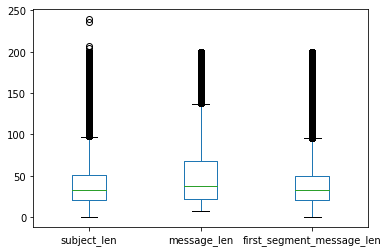

In [14]:
# Commit Message & Subject Length Distribution
fig, axes = plt.subplots()
commit_messages["subject_len"] = commit_messages["subject"].str.len()
commit_messages["message_len"] = commit_messages["message"].str.len()
commit_messages["first_segment_message_len"] = commit_messages["message"].str.split("\n").str.get(0).str.len()
commit_messages.plot.box(y=["subject_len", "message_len", "first_segment_message_len"], ax=axes)

### Build Rule System that create dependent variable
Can be run independently against previous section

In [15]:
import pandas as pd
from pandarallel import pandarallel
import numpy as np
import spacy

pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
%%capture
!python -m spacy download en_core_web_sm
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [17]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [34]:
data_dir = "./data/"
data_path = os.path.join(data_dir, "commit_messages.parquet")
tagged_data_path = os.path.join(data_dir, "commit_messages_with_label.parquet")
print(data_path)
print(tagged_data_path)

./data/commit_messages.parquet
./data/commit_messages_with_label.parquet


In [36]:
commit_messages = pd.read_parquet(data_path)
print(commit_messages.shape)

(1000000, 5)


In [37]:
raw_identifiers = ["fix", "update", "rework", "merge", "add", "polish", \
                   "resolve", "rename", "refactor", "remove", "implement", \
                   "style", "test", "docs", "chore", "feat"]
identifiers = set([nlp(word)[0].lemma_ for word in raw_identifiers])
print(identifiers)

{'test', 'add', 'fix', 'resolve', 'implement', 'docs', 'chore', 'rework', 'polish', 'refactor', 'update', 'style', 'rename', 'merge', 'feat', 'remove'}


In [38]:
def create_dependant_variable(row, debug=False):
    message_doc = nlp(row["first_segment_message"])
    subject_doc = nlp(row["subject"])
    
    identifier_exist = None
    not_overlength = None
    capitalized_first_token = None
    not_period_end = None
    first_alpha_word_verb = None
    
    try:
        if message_doc.__len__() > 0 and subject_doc.__len__() > 0:
            identifier_exist = False
            # identifier detection
            for token in subject_doc:
                if token.lemma_ in identifiers:
                    identifier_exist = True
                    break
                else:
                    continue
            if identifier_exist is False:
                for token in message_doc:
                    if token.lemma_ in identifiers:
                        identifier_exist = True
                        break
                    else:
                        continue
            # subject is less then 50 characters
            not_overlength = subject_doc.text.__len__() <= 50
            # both subject and first segment message is captialized
            capitalized_first_token = message_doc[0].is_title and subject_doc[0].is_title
            # subject period end flag
            not_period_end = subject_doc[-1].text != "."
            # first word is verb in subject
            first_alpha_word_verb = False
            for token in subject_doc:
                if token.is_alpha == True and token.pos_ == "VERB":
                    first_alpha_word_verb = True
                    break
            final = all([identifier_exist, not_overlength, capitalized_first_token, \
                         not_period_end, first_alpha_word_verb])
            if debug is True:
                print(message_doc, "\n...", identifier_exist, not_overlength, capitalized_first_token, \
                      not_period_end, first_alpha_word_verb, "--> Final Judgement: ", final)
        else:
            final = False
            if debug is True:
                print(message_doc, "\n...", "empty message body found, assigning bad message")
    except Exception as e:
        print(f"WARNING: message {message_doc[:10]}... and subject {subject_doc[:10]}... raised exception {e}")
    finally:
        return {"identifier": identifier_exist, \
                "length_ok": not_overlength, \
                "capital_first_token": capitalized_first_token, \
                "not_period_end": not_period_end, \
                "imperative_mood": first_alpha_word_verb, \
                "good_message": final}
        
sample = commit_messages.head(10)
_ = sample.apply(lambda x: create_dependant_variable(x, debug=True), axis=1)

Update issue 4491
Labels: ReadyForRelease
-Show a different debug log message if the page is whitelisted
-The variable debug_background is never read and can be removed 
... True False True True True --> Final Judgement:  False
Use the file in the inlined die rather than the compile unit for
backtrace locations. 
... False False True False True --> Final Judgement:  False
Minor bug fix. Selecting different rule types from the rule selection frame
was clearing the selected permissions in the permissions listbox. 
... True False True False True --> Final Judgement:  False
Null-Merge commit '5f2c4f1' into cg_merges_20130606b 
... False False True True False --> Final Judgement:  False
clang-format: Fix space in decltype-constexprs. 
... True True False False False --> Final Judgement:  False
Added Cm coef return                  
... True True True True True --> Final Judgement:  True
Update svn:ignore properties. 
... True True True False False --> Final Judgement:  False
Bump self after

In [40]:
## Label Distribution
fetched = commit_messages.copy()
print("Start Parallel Mapping ...")
resp = fetched.parallel_apply(lambda x: create_dependant_variable(x), axis=1)
print("Finished Parallel Mapping ...")

resp_df = pd.DataFrame.from_records(resp).fillna(False)
commit_messages_with_label = pd.concat([fetched, resp_df], axis=1)

resp_df.groupby("good_message") \
    .agg({"identifier": ["count", "sum"], \
          "length_ok": ["count", "sum"], \
          "capital_first_token": ["count", "sum"], \
          "not_period_end": ["count", "sum"], \
          "imperative_mood": ["count", "sum"]}) \
    .astype(int)

Start Parallel Mapping ...
Finished Parallel Mapping ...


identifier         length_ok         capital_first_token          \
                  count     sum     count     sum               count     sum   
good_message                                                                    
False            864658  365786    864658  608793              864658  446303   
True             135342  135342    135342  135342              135342  135342   

             not_period_end         imperative_mood          
                      count     sum           count     sum  
good_message                                                 
False                864658  726655          864658  536140  
True                 135342  135342          135342  135342

In [41]:
## Manual Review the True Sample is what we want
commit_messages_with_label.loc[commit_messages_with_label["good_message"] == True]

,name,time_sec,subject,message,first_segment_message,identifier,length_ok,capital_first_token,not_period_end,imperative_mood,good_message
5,Greg Hayman,1433352768,Added Cm coef return,Added Cm coef return \n\ngit-s...,Added Cm coef return,True,True,True,True,True,True
21,Anthony Cros,1378847548,Merge branch 'develop' into feature/misc-fixes-2,Merge branch 'develop' into feature/misc-fixes...,Merge branch 'develop' into feature/misc-fixes-2,True,True,True,True,True,True
23,동준,1437028953,Merge remote-tracking branch 'origin/master',Merge remote-tracking branch 'origin/master'\n...,Merge remote-tracking branch 'origin/master',True,True,True,True,True,True
28,Sergey Pevnev,1443697698,Merge branch 'f-sdk' into f-runtime,Merge branch 'f-sdk' into f-runtime\n\nConflic...,Merge branch 'f-sdk' into f-runtime,True,True,True,True,True,True
29,Greg Leclercq,1267196345,Merge branch 'unstable' of from chty into unst...,Merge branch 'unstable' of from chty into unst...,Merge branch 'unstable' of from chty into unst...,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
999974,GitHub,1490657211,Add files via upload,Add files via upload,Add files via upload,True,True,True,True,True,True
999975,GitHub,1542160700,Complete the test of sqlparser (#32),Complete the test of sqlparser (#32)\n\n* Fix ...,Complete the test of sqlparser (#32),True,True,True,True,True,True
999982,GitHub,1555700244,Merge pull request #58 from shapeblue/refactor,Merge pull request #58 from shapeblue/refactor...,Merge pull request #58 from shapeblue/refactor,True,True,True,True,True,True
999990,GitHub,1553858575,Merge branch 'hotfix-4.6.x' into hotfix-4.6.x,Merge branch 'hotfix-4.6.x' into hotfix-4.6.x,Merge branch 'hotfix-4.6.x' into hotfix-4.6.x,True,True,True,True,True,True


In [42]:
commit_messages_with_label.to_parquet(tagged_data_path, index=False)

### Split Datasets

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [15]:
data_dir = "./data/"
data_path = os.path.join(data_dir, "commit_messages.parquet")
tagged_data_path = os.path.join(data_dir, "commit_messages_with_label.parquet")
tagged_trainset_path = os.path.join(data_dir, "labeled_commit_message_train.parquet")
tagged_devset_path = os.path.join(data_dir, "labeled_commit_message_dev.parquet")
tagged_testset_path = os.path.join(data_dir, "labeled_commit_message_test.parquet")
print(data_path)
print(tagged_data_path)
print("...", tagged_trainset_path)
print("...", tagged_devset_path)
print("...", tagged_testset_path)

./data/commit_messages.parquet
./data/commit_messages_with_label.parquet
... ./data/labeled_commit_message_train.parquet
... ./data/labeled_commit_message_dev.parquet
... ./data/labeled_commit_message_test.parquet


In [8]:
tagged_data = pd.read_parquet(tagged_data_path)
tagged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   name                   1000000 non-null  object
 1   time_sec               1000000 non-null  int64 
 2   subject                1000000 non-null  object
 3   message                1000000 non-null  object
 4   first_segment_message  1000000 non-null  object
 5   identifier             1000000 non-null  bool  
 6   length_ok              1000000 non-null  bool  
 7   capital_first_token    1000000 non-null  bool  
 8   not_period_end         1000000 non-null  bool  
 9   imperative_mood        1000000 non-null  bool  
 10  good_message           1000000 non-null  bool  
dtypes: bool(6), int64(1), object(4)
memory usage: 43.9+ MB


In [14]:
traindev_set, test_set = train_test_split(tagged_data, random_state=127, \
                                          stratify=tagged_data["good_message"].values)
train_set, dev_set = train_test_split(traindev_set, random_state=127, \
                                      stratify=traindev_set["good_message"].values)
print(">>> Train / Dev / Test Set Shape")
print(train_set.shape, dev_set.shape, test_set.shape)

print("\n>>> Train / Dev / Test Set Label Distribution")
display(pd.concat([train_set["good_message"].value_counts(), \
                   dev_set["good_message"].value_counts(), \
                   test_set["good_message"].value_counts()], 
                  axis=1, keys=["train", "dev", "test"]))

>>> Train / Dev / Test Set Shape
(562500, 11) (187500, 11) (250000, 11)

>>> Train / Dev / Test Set Label Distribution


,train,dev,test
False,486371,162123,216164
True,76129,25377,33836


In [16]:
train_set.to_parquet(tagged_trainset_path, index=False)
dev_set.to_parquet(tagged_devset_path, index=False)
test_set.to_parquet(tagged_testset_path, index=False)

### Baseline Model

In [4]:
import sagemaker
import pandas as pd
import numpy as np
import os

In [6]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()
print(sagemaker_session)
print(role)
print(bucket)

arn:aws:iam::259046265119:role/service-role/AmazonSageMaker-ExecutionRole-20200813T153989
sagemaker-us-east-1-259046265119


In [5]:
data_dir = "./data/"
data_path = os.path.join(data_dir, "commit_messages.parquet")
tagged_data_path = os.path.join(data_dir, "commit_messages_with_label.parquet")
tagged_trainset_path = os.path.join(data_dir, "labeled_commit_message_train.parquet")
tagged_devset_path = os.path.join(data_dir, "labeled_commit_message_dev.parquet")
tagged_testset_path = os.path.join(data_dir, "labeled_commit_message_test.parquet")
print(data_path)
print(tagged_data_path)
print("...", tagged_trainset_path)
print("...", tagged_devset_path)
print("...", tagged_testset_path)

./data/commit_messages.parquet
./data/commit_messages_with_label.parquet
... ./data/labeled_commit_message_train.parquet
... ./data/labeled_commit_message_dev.parquet
... ./data/labeled_commit_message_test.parquet


In [9]:
train_set = pd.read_parquet(tagged_trainset_path)
dev_set = pd.read_parquet(tagged_devset_path)
test_set = pd.read_parquet(tagged_testset_path)
print(train_set.shape, dev_set.shape, test_set.shape)

display(train_set.head())

(562500, 11) (187500, 11) (250000, 11)


,name,time_sec,subject,message,first_segment_message,identifier,length_ok,capital_first_token,not_period_end,imperative_mood,good_message
0,Magenik,1421858642,Timeline update,Timeline update\n,Timeline update\n,True,True,True,True,False,False
1,polytomous,1509246803,Extract parameter on breakCurrentBlock TF2John,Extract parameter on breakCurrentBlock TF2John\n,Extract parameter on breakCurrentBlock TF2John\n,False,True,True,True,True,False
2,mero,1348444108,updated changelog,updated changelog\n,updated changelog\n,True,True,False,True,True,False
3,YominCarr,1414094992,Cleanup,Cleanup\n,Cleanup\n,False,True,True,True,False,False
4,Anthony Fuentes,1556550569,[maint] Updating copyright,[maint] Updating copyright\n,[maint] Updating copyright\n,True,True,False,True,True,False


In [13]:
# specify an output path
prefix = 'commit_msg'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = sagemaker.LinearLearner(role=role,
                                 instance_count=1, 
                                 instance_type='ml.c4.xlarge',
                                 predictor_type='binary_classifier',
                                 output_path=output_path,
                                 sagemaker_session=sagemaker_session,
                                 epochs=15)

In [21]:
train_x_np = train_set.loc[:, ["identifier", "length_ok", "capital_first_token", "not_period_end", "imperative_mood"]].astype('float32').values
train_y_np = train_set.loc[:, "good_message"].astype('float32').values
print(train_x_np.shape, train_y_np.shape)
display(train_x_np[:5])

# create RecordSet
formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

(562500, 5) (562500,)


array([[1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [0., 1., 1., 1., 0.],
       [1., 1., 0., 1., 1.]], dtype=float32)

In [22]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-22 03:40:05 Starting - Starting the training job...
2020-11-22 03:40:07 Starting - Launching requested ML instances......
2020-11-22 03:41:20 Starting - Preparing the instances for training.........
2020-11-22 03:42:57 Downloading - Downloading input data...
2020-11-22 03:43:29 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/22/2020 03:43:34 INFO 139668708329280] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'in

In [23]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!CPU times: user 288 ms, sys: 12.8 ms, total: 301 ms
Wall time: 9min 32s


In [25]:
# test one prediction
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

test_x_np = test_set.loc[:, ["identifier", "length_ok", "capital_first_token", "not_period_end", "imperative_mood"]].astype('float32').values
test_y_np = test_set.loc[:, "good_message"].astype('float32').values


metrics = evaluate(linear_predictor, 
                   test_x_np.astype('float32'), 
                   test_y_np, 
                   verbose=True) # verbose means we'll print out the metrics

prediction (col)     0.0    1.0
actual (row)                   
0.0               209305   6859
1.0                    0  33836

Recall:     1.000
Precision:  0.831
Accuracy:   0.973



In [26]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
    try:
        boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
        print('Deleted {}'.format(predictor.endpoint))
    except:
        print('Already deleted: {}'.format(predictor.endpoint))
        
delete_endpoint(linear_predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Already deleted: linear-learner-2020-11-22-03-51-53-788


### Create Features and Feature Transform

### Model Training

### Model Deployment